In [1]:
%matplotlib inline
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from vgg16 import vgg16
from dataLoader import *

### Data download
  - 다운로드 제대로 된 후에는 다시 실행할 필요 없습니다 :)

In [2]:
if not os.path.exists('resource/vgg16_weights.npz'):
    # download images
    os.system('wget cvlab.postech.ac.kr/~jonghwan/224x224_mscoco_images.tar.gz')
    os.system('tar xvzf 224x224_mscoco_images.tar.gz')
    os.system('rm 224x224_mscoco_images.tar.gz')
    os.system('mv 224x224_mscoco_images resource/224x224_mscoco_images')

    # download vgg16 network
    os.system('wget cvlab.postech.ac.kr/~jonghwan/vgg16_weights.npz')
    os.system('mv vgg16_weights.npz resource/vgg16_weights.npz')

### Captioning Network Definition

In [3]:
class Caption_Generator():
    def init_weight(self, dim_in, dim_out, name=None, stddev=1.0):
        return tf.Variable(tf.truncated_normal([dim_in, dim_out], stddev=stddev/math.sqrt(float(dim_in))), name=name)

    def init_bias(self, dim_out, name=None):
        return tf.Variable(tf.zeros([dim_out]), name=name)

    def __init__(self, params, bias_init_vector=None):
        #dim_image, dim_embed, dim_hidden, batch_size, n_lstm_steps, n_words, bias_init_vector=None):
        
        self.wtoi = params['wtoi']
        self.vgg16_weight_file = params['vgg16_weight_file']
        
        # captioning model parameter dimensions
        self.dim_image_feat = np.int(params['dim_image'])
        self.dim_word_embedding = np.int(params['dim_embed'])
        self.dim_hidden_lstm = np.int(params['dim_hidden'])
        self.batch_size = np.int(params['batch_size'])
        self.n_lstm_steps = np.int(params['n_lstm_steps'])
        self.n_words = np.int(params['n_words'])
        
        self.initializer = tf.random_uniform_initializer(minval=-0.8, maxval=0.8)

    def build_model(self, sess):
        """ Build captioning model for training"""

        image = tf.placeholder(tf.float32, [self.batch_size, 224, 224, 3])
        input_labels = tf.placeholder(tf.int32, [self.batch_size, self.n_lstm_steps])
        target_labels = tf.placeholder(tf.int32, [self.batch_size, self.n_lstm_steps])
        mask = tf.placeholder(tf.float32, [self.batch_size, self.n_lstm_steps])

        # extract image feature
        vgg = vgg16(image, self.vgg16_weight_file, sess, trainable=False)
        image_feat = vgg.fc7
        
        # embed image feature to match the dimension of lstm input
        with tf.variable_scope("image_embedding") as img_embed_scope:
            image_embeddings = tf.contrib.layers.fully_connected(
                                    inputs=image_feat,
                                    num_outputs=self.dim_hidden_lstm,
                                    activation_fn=None,
                                    weights_initializer=self.initializer,
                                    biases_initializer=None,
                                    scope=img_embed_scope)
            
        # embed input caption labels to obtain word embeddings
        with tf.variable_scope("word_embedding"), tf.device('/cpu:0'):
            word_embedding_matrix = tf.get_variable(
                                        name='word_embedding_matrix',
                                        shape=[self.n_words, self.dim_word_embedding],
                                        initializer=self.initializer
                                        )
            word_embeddings = tf.nn.embedding_lookup(word_embedding_matrix, input_labels)
                                                            
        
        # for LSTM cell unit
        with tf.variable_scope("lstm", initializer=self.initializer) as lstm_scope:
            lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=self.dim_hidden_lstm, state_is_tuple=True)
            zero_state = lstm_cell.zero_state(self.batch_size, dtype=tf.float32)
            _, initial_state = lstm_cell(image_embeddings, zero_state)
            
            # allow the LSTM variables to be resued
            lstm_scope.reuse_variables()
            
            # run the batch of word embeddings throught the LSTM
            caption_length = tf.reduce_sum(mask, 1)
            lstm_outputs, _ = tf.nn.dynamic_rnn(cell=lstm_cell,
                                               inputs=word_embeddings,
                                               sequence_length=caption_length,
                                               initial_state=initial_state,
                                               dtype=tf.float32,
                                               scope=lstm_scope)
        
        # stack batches vertically
        lstm_outputs = tf.reshape(lstm_outputs, [-1, lstm_cell.output_size])
        
        # compute probabilities for words
        with tf.variable_scope("logits") as logits_scope:
            logits = tf.contrib.layers.fully_connected(
                        inputs=lstm_outputs,
                        num_outputs=self.n_words,
                        activation_fn=None,
                        weights_initializer=self.initializer,
                        scope=logits_scope)
        
        targets = tf.reshape(target_labels, [-1])
        weights = tf.to_float(tf.reshape(mask, [-1]))
        
        # compute losses
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets,
                                                              logits=logits)
        batch_loss = tf.div(tf.reduce_sum(tf.multiply(losses, weights)),
                            tf.reduce_sum(weights), name="batch_loss")
        tf.losses.add_loss(batch_loss)
        total_loss = tf.losses.get_total_loss()
        
        probs = tf.nn.softmax(logits, name='softmax')

        return image, input_labels, target_labels, mask, total_loss, probs

    def build_generator(self, sess):
        """ Build captioning model for test"""
        
        # extract image feature
        image = tf.placeholder(tf.float32, [self.batch_size, 224, 224, 3], name='image_raw')
        vgg = vgg16(image, self.vgg16_weight_file, sess, trainable=False)
        image_feat = vgg.fc7
        
        # embed image feature to match the dimension of lstm input
        with tf.variable_scope("image_embedding") as img_embed_scope:
            encoded_images = tf.contrib.layers.fully_connected(
                                    inputs=image_feat,
                                    num_outputs=self.dim_hidden_lstm,
                                    activation_fn=None,
                                    weights_initializer=self.initializer,
                                    biases_initializer=None,
                                    scope=img_embed_scope)
        
        
        
        # Below part is for caption generation (LSTM)
        image_embeddings = tf.placeholder(dtype=tf.float32,
                                          shape=[self.batch_size, self.dim_hidden_lstm],
                                          name='image_feed')
        input_feed = tf.placeholder(dtype=tf.int64, shape=[None], name='input_feed')
        input_labels = tf.expand_dims(input_feed, 1)

        # embed input caption labels to obtain word embeddings
        with tf.variable_scope("word_embedding"), tf.device('/cpu:0'):
            word_embedding_matrix = tf.get_variable(
                                        name='word_embedding_matrix',
                                        shape=[self.n_words, self.dim_word_embedding],
                                        initializer=self.initializer
                                        )
            word_embeddings = tf.nn.embedding_lookup(word_embedding_matrix, input_labels)                                                            
        
        # for LSTM cell unit    
        with tf.variable_scope("lstm", initializer=self.initializer) as lstm_scope:
            lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=self.dim_hidden_lstm, state_is_tuple=True)
            zero_state = lstm_cell.zero_state(self.batch_size, dtype=tf.float32)
            _, initial_state = lstm_cell(image_embeddings, zero_state)
            
            # allow the LSTM variables to be resued
            lstm_scope.reuse_variables()
            
            # In inference mode, use concatenated states for convenient feeding and fetching.
            tf.concat(axis=1, values=initial_state, name="initial_state")
        
        
            # Placeholder for feeding a batch of concatenated states.
            state_feed = tf.placeholder(dtype=tf.float32,
                                        shape=[None, sum(lstm_cell.state_size)],
                                        name="state_feed")
            state_tuple = tf.split(value=state_feed, num_or_size_splits=2, axis=1)

            # Run a single LSTM step.
            lstm_outputs, state_tuple = lstm_cell(
                inputs=tf.squeeze(word_embeddings, axis=[1]), state=state_tuple)

            #lstm_outputs, state_tuple = tf.nn.dynamic_rnn(cell=lstm_cell,
            #                                   inputs=word_embeddings,
            #                                   initial_state=state_tuple,
            #                                   dtype=tf.float32,
            #                                   scope=lstm_scope)
            
            # Concatentate the resulting state.
            tf.concat(axis=1, values=state_tuple, name="state")
            
        
        # stack batches vertically
        lstm_outputs = tf.reshape(lstm_outputs, [-1, lstm_cell.output_size])
        
        # compute probabilities for words
        with tf.variable_scope("logits") as logits_scope:
            logits = tf.contrib.layers.fully_connected(
                        inputs=lstm_outputs,
                        num_outputs=self.n_words,
                        activation_fn=None,
                        weights_initializer=self.initializer,
                        scope=logits_scope)
        probs = tf.nn.softmax(logits, name='softmax')

        return image, encoded_images, image_embeddings, state_feed, probs

In [4]:
################### Parameters #####################
train_params = {
    'json_path':'resource/train.json',
    'h5py_path':'resource/train.h5',
    'img_dir': 'resource/224x224_mscoco_images/'
}
test_params = {
    'json_path':'resource/test.json',
    'h5py_path':'resource/test.h5',
    'img_dir': 'resource/224x224_mscoco_images/'
}
# create data loader for training and test data
loaders = {}
loaders['train'] = dataLoader(train_params)
loaders['test'] = dataLoader(test_params)

model_params = {
    'wtoi': loaders['train'].getWtoi(),
    'vgg16_weight_file': 'resource/vgg16_weights.npz',
    'dim_image': 4096, # dimension of vgg16 network output
    'dim_embed': 256,
    'dim_hidden': 256,
    'batch_size': 50,
    'n_lstm_steps': loaders['train'].getMaxCaptionLength(),
    'n_words': loaders['train'].getVocabSize(),
}


def train():
    n_epochs = 100
    learning_rate = 0.001
    model_path = './models'
    itow = loaders['test'].getItow()
    
    with tf.Session() as sess:
    
        caption_generator = Caption_Generator(model_params)#, bias_init_vector=bias_init_vector)
        image, input_labels, target_labels, mask, loss, prob = caption_generator.build_model(sess)

        saver = tf.train.Saver(max_to_keep=50)
        train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
        sess.run(tf.global_variables_initializer())

        iteration_per_epoch = loaders['train'].getNumCaptions() / model_params['batch_size']
        for epoch in range(n_epochs):
            for bi in range(iteration_per_epoch):
                # load batch data
                batch = loaders['train'].getBatch(model_params['batch_size'])

                #if bi % 50 == 0: 
                _, prob_value, loss_value = sess.run([train_op, prob, loss], 
                                         feed_dict={image: batch['images'],
                                                    input_labels: batch['caption_labels'],
                                                    target_labels: batch['target_labels'],
                                                    mask: batch['caption_masks']}
                                        )

                if bi % 50 == 0:
                    single_sample = []
                    word_index = np.argmax(prob_value, 1)
                    for wi in range(15):
                        single_sample.append(word_index[wi])
                    word_index = np.hstack(single_sample)

                    generated_sentence = ''
                    for w in word_index:
                        word = itow[str(w)]
                        if word == '<E>': break
                        else:
                            generated_sentence += (word + ' ')

                    print('Sampled caption: ', generated_sentence)
                    print "%d epoch %d iteration Cost: %.4f" % (epoch+1, bi, loss_value)

            print "Epoch ", epoch+1, " is done. Saving the model ... "
            if not os.path.isdir(model_path):
                os.makedirs(model_path)
            saver.save(sess, os.path.join(model_path, 'model'), global_step=epoch+1)
            learning_rate *= 0.95

In [5]:
def embedding_images(sess, images, encoded_images):
    embedded_images = sess.run(encoded_images, feed_dict={'image_raw:0': images})
    return embedded_images

def feed_image(sess, encoded_image):
    initial_state = sess.run(fetches='lstm/initial_state:0',
                            feed_dict={'image_feed:0': encoded_image})
    return initial_state
    

def inference_step(sess, input_feed, state_feed):
    softmax_output, state_output = sess.run(
        fetches=["softmax:0", "lstm/state:0"],
        feed_dict={
            "input_feed:0": input_feed,
            "lstm/state_feed:0": state_feed,
        })
    return softmax_output, state_output, None


def test(model_path='./models/model-0', maxlen=15):
    tf.reset_default_graph()
    with tf.Session() as sess:
    
        # create caption generator for test
        model_params['batch_size'] = 1
        caption_generator = Caption_Generator(model_params)
        image, image_feat, image_embed, s_feed, prob = caption_generator.build_generator(sess=sess)

        # load the model parameters
        saver = tf.train.Saver()
        saver.restore(sess, model_path)

        itow = loaders['test'].getItow()
        start_idx = loaders['test'].getWtoi()['<S>']
        n_steps = loaders['train'].getMaxCaptionLength()
        predictions = []
        iteration_per_epoch = loaders['test'].getNumCaptions() / model_params['batch_size']
        for bi in range(100):
            # load batch data
            batch = loaders['test'].getBatch(model_params['batch_size'])

            # extract vgg feature
            encoded_images = embedding_images(sess, batch['images'], image_feat)
            input_feed = np.full((model_params['batch_size']), start_idx)
            state_feed = feed_image(sess, encoded_images) # initial state
            
            generated_word_index = []
            for ci in range(n_steps):
                softmax, next_states, metadata = inference_step(sess, input_feed, state_feed)
                
                input_feed = np.argmax(softmax,1)
                state_feed = next_states
                
                generated_word_index.append(input_feed)            
            
            generated_sentence = ''
            for w in generated_word_index:
                word = itow[str(w[0])]
                if word == '<E>': break
                else:
                    generated_sentence += (word + ' ')

            img = np.asarray(batch['images'].reshape(224,224,3) 
                             + np.array([123.68, 116.779, 103.939]).reshape(1,1,3),dtype='uint8')
            I=Image.fromarray(img)
            fig,ax=plt.subplots(1,1)
            ax[0].imshow(I)
            plt.show()

            print('Generated Caption: ', generated_sentence)

            ith_prediction = {}
            ith_prediction['image_id'] = batch['image_ids'][0]
            ith_prediction['caption'] = generated_sentence
            predictions.append(ith_prediction)
            

        # save the prediction outputs
        if not os.path.isdir('result'):
                os.makedirs('result')
        write_json('result/predictions.json', predictions)
        print('Save the predictions to result/predictions.json')

### Training and Testing Model

In [6]:
# test model that means to predict captions for test images
do_train = False
if do_train:
    train()

[1]
[12]
[11]
[14]
[5]
[1]
[25]
[9]
[1]
[97]
[4]
[3]
[0]
[4]
[3]


TypeError: 'AxesSubplot' object does not support indexing

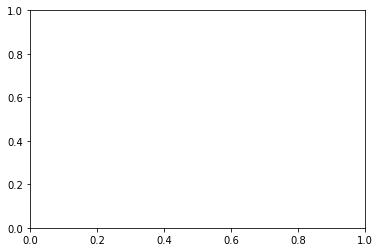

In [7]:
# test model that means to predict captions for test images
if not do_train:
    test(model_path='models/model.ckpt-1')

### Evaluation

In [ ]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file

print_tensors_in_checkpoint_file('models/model.ckpt-1', tensor_name='lstm/basic_lstm_cell/weights', all_tensors=False)

In [ ]:
%matplotlib inline
import sys
sys.path.append('coco-caption')

from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import matplotlib.pyplot as plt
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [ ]:
ann_file = 'coco-caption/annotations/captions_val2014.json'
res_file = 'result/predictions.json'

In [ ]:
# create coco object and cocoRes object
coco = COCO(ann_file)
cocoRes = coco.loadRes(res_file)

In [ ]:
# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(coco, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
cocoEval.evaluate()

# 